In [38]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


## 프로젝트 루브릭

데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?

제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?

다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

### 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?

#### 데이터 이해하기

In [39]:
import pandas as pd

df_train = pd.read_csv('data/train.csv')
df_test  = pd.read_csv('data/test.csv')

print(len(df_train))
print(len(df_test))

print(f'train data dim : {df_train.shape}')
print(f'sub data dim : {df_test.shape}')

15035
6468
train data dim : (15035, 21)
sub data dim : (6468, 20)


In [40]:
set(df_train.columns) - set(df_test.columns)

{'price'}

In [41]:
y_train = df_train['price']
print(y_train.head())

0    221900.0
1    180000.0
2    510000.0
3    257500.0
4    291850.0
Name: price, dtype: float64


In [42]:
X_train = df_train.copy().drop(columns='price')
print(X_train.head())

   id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  20141013T000000         3       1.00         1180      5650     1.0   
1   1  20150225T000000         2       1.00          770     10000     1.0   
2   2  20150218T000000         3       2.00         1680      8080     1.0   
3   3  20140627T000000         3       2.25         1715      6819     2.0   
4   4  20150115T000000         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   
3           0     0          3      7        1715              0      1995   
4           0     0          3      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqf

In [43]:
X_test = df_test.copy()

data = pd.concat((X_train, X_test), axis=0)


In [44]:
# 결측치 확인

for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [45]:
# 데이터 정리

# id와 인덱스가 동일
del X_train['id']
del X_test['id']

X_train['date'] = X_train['date'].apply(lambda x: str(x[:6]))
X_test['date'] = X_test['date'].apply(lambda x: str(x[:6]))

X_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


모델 설계

In [46]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [47]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [48]:
y_pred = AveragingBlending(models, X_train, y_train, X_test)
print(len(y_pred))
y_pred

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 540682.653143
6468


array([ 548944.53804912,  443655.17105951, 1345797.07909443, ...,
        457185.23303678,  339532.04977609,  422564.70651683])

In [49]:
result = pd.DataFrame({
    'id' : df_test['id'], 
    'price' : y_pred
})
print(len(result))
result.head()

6468


,id,price
0,15035,5.489445e+05
1,15036,4.436552e+05
2,15037,1.345797e+06
3,15038,3.206119e+05
4,15039,3.180479e+05


In [51]:
my_submission_path = 'data'
result.to_csv(my_submission_path + '/submission.csv', index=False)
print(my_submission_path)

data


<Axes: xlabel='price', ylabel='Density'>

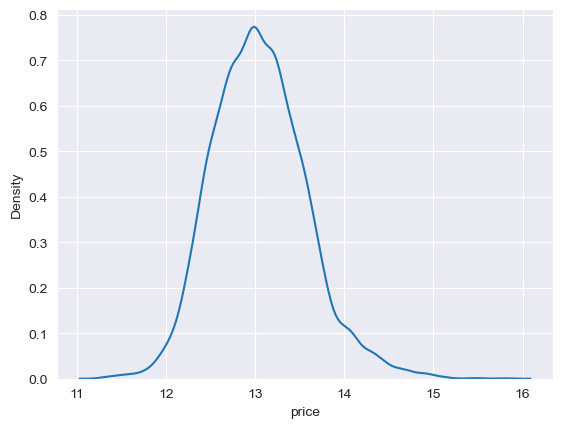

In [55]:
y_train = np.log1p(y_train)
sns.kdeplot(y_train)

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [58]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [59]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [60]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [66]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
    # [[YOUR CODE]]
    Input_train, Input_test, target_train, target_test = train_test_split(
        X_train, y_train, test_size=0.2, random_state=random_state)
    
    print(Input_train.describe())

    # 모델 학습
    # [[YOUR CODE]]
    model.fit(Input_train, target_train)
    
    # 예측
    # [[YOUR CODE]]
    target_pred = model.predict(Input_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(target_test, target_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

          bedrooms    bathrooms   sqft_living      sqft_lot       floors  \
count  7697.000000  7697.000000   7697.000000  7.697000e+03  7697.000000   
mean      3.365987     2.113031   2081.563077  1.534418e+04     1.497661   
std       0.901028     0.772324    934.763351  4.188029e+04     0.541838   
min       0.000000     0.000000    290.000000  5.720000e+02     1.000000   
25%       3.000000     1.500000   1420.000000  5.016000e+03     1.000000   
50%       3.000000     2.250000   1900.000000  7.620000e+03     1.500000   
75%       4.000000     2.500000   2560.000000  1.050700e+04     2.000000   
max      10.000000     8.000000  13540.000000  1.024068e+06     3.500000   

        waterfront         view    condition        grade   sqft_above  \
count  7697.000000  7697.000000  7697.000000  7697.000000  7697.000000   
mean      0.007146     0.247889     3.409640     7.662726  1787.921528   
std       0.084235     0.789667     0.647982     1.193496   834.834399   
min       0.000000 

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:date: object